In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(platetools)))
suppressWarnings(suppressPackageStartupMessages(library(gridExtra)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(viridis)))
suppressWarnings(suppressPackageStartupMessages(library(argparse)))    

In [ ]:
# set up argparse
parser <- arg_parser("Visualize regression results")

parser <- add_argument(parser, "--cell_type", help = "String of the type of cell used", required = TRUE)

args <- parse_args(parser)

cell_type <- args$cell_type

In [2]:
cell_type <- "PBMC"

In [3]:

df_stats_path <- file.path(
    paste0("../results/regression/",cell_type,"/aggregated_with_nomic/model_stats.csv"
    )
)
df_variance_path <- file.path(
    paste0("../results/regression/",cell_type,"/aggregated_with_nomic/variance_r2_stats.csv"
    )
)
# import csv file
df <- read.csv(df_stats_path)
df_var <- read.csv(df_variance_path)

# set up figure path
enet_cp_fig_path <- paste0("../figures/regression/",cell_type,"/aggregated_with_nomic/")


# if path does not exist, create it
if (!file.exists(dirname(enet_cp_fig_path))) {
    print(dirname(enet_cp_fig_path))
    dir.create(dirname(enet_cp_fig_path), recursive = TRUE)
}

In [4]:
print(unique(df$shuffle))
print(length(unique(df$cytokine)))

[1] "final"             "shuffled_baseline"
[1] 187


In [5]:
# set output path
global_prediction_trend_path <- file.path(paste0(enet_cp_fig_path,"global_prediction_trend.png"))
# if path does not exist, create it
if (!file.exists(dirname(global_prediction_trend_path))) {
    print(dirname(global_prediction_trend_path))
    dir.create(dirname(global_prediction_trend_path), recursive = TRUE)
}
# plot the data
global_prediction_trend_scatter <- (
    ggplot(df, aes(x=actual_value, y=predicted_value, col=shuffle))
    + geom_point(alpha=0.5, size=0.5) 
    # add geom smooth with each line being a different color
    + labs(x="Actual", y="Predicted") 
    + theme_bw()
    + labs(title="Global Prediction Trends of Cytokine Concentrations")
    # add y=x line
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    + facet_wrap(~shuffle, ncol=2)
)

# save the plot
ggsave(global_prediction_trend_path, global_prediction_trend_scatter, width=5, height=5, dpi=500)
global_prediction_trend

global_prediction_trend_line <- (
    ggplot(df, aes(x=actual_value, y=predicted_value, col=shuffle)) 
    # add geom smooth with each line being a different color
    + geom_smooth(method="lm", se=TRUE, alpha=0.5, size=0.5, aes(col=shuffle))
    # make colors different for each line
    + scale_color_viridis(discrete=TRUE, option="plasma")
    + labs(x="Actual", y="Predicted") 
    + theme_bw()
    + labs(title="Global Prediction Trends of Cytokine Concentrations")
    # add y=x line
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    + facet_wrap(~shuffle, ncol=2)
    + ylim(0, 1)
    + xlim(0, 1)
)
ggsave(global_prediction_trend_path, global_prediction_trend_line, width=5, height=5, dpi=500)
global_prediction_trend_line

ERROR: Error in eval(expr, envir, enclos): object 'global_prediction_trend' not found


In [ ]:
head(df)

In [ ]:
enet_cp_fig <- file.path(paste0(enet_cp_fig_path,"Predicted_vs_Actual_all_cytokines.pdf"))
pdf(file=enet_cp_fig)
# set plot size
options(repr.plot.width=6, repr.plot.height=8)
# facet by secrete 
for (i in 1:length(unique(df$cytokine))){
    sub_df <- df[df$cytokine == (unique(df$cytokine)[i]),]
    p <- (
        ggplot(sub_df, aes(x=actual_value, y=predicted_value, col=shuffle)) 
        + geom_point() 
        + geom_smooth(method=lm, se=TRUE, formula = y ~ x) 
        + labs(x="Actual", y="Predicted") 
        + theme_bw() 
        + ggtitle(unique(df$cytokine)[i])
        + ylim(0, 1)
        + xlim(0, 1)

    )
    
    plot(p)
}
dev.off()


In [ ]:
# remove '[]' from the string in the column
df_var$r2 <- gsub("\\[|\\]", "", df_var$r2)
# set the column as numeric
df_var$r2 <- as.numeric(df_var$r2)
head(df_var)

In [ ]:
# set output path
global_variance_r2_path <- file.path(paste0(enet_cp_fig_path,"global_variance_r2.png"))
# if path does not exist, create it
if (!file.exists(dirname(global_prediction_trend_path))) {
    print(dirname(global_prediction_trend_path))
    dir.create(dirname(global_prediction_trend_path), recursive = TRUE)
}
# plot df_var df
variance_r2_plot <- (
    ggplot(df_var, aes(x=r2, y=actual_value,col=shuffle, shape = data_split)) 
    + geom_point() 
    # + geom_smooth(method=lm, se=TRUE) 
    + labs(x="r2", y="variance") 
    + theme_bw()
)
ggsave(global_variance_r2_path, variance_r2_plot, width=5, height=5, dpi=500)
variance_r2_plot

local_variance_r2_path <- file.path(paste0(enet_cp_fig_path,"local_variance_r2.png"))
# if path does not exist, create it
if (!file.exists(dirname(global_prediction_trend_path))) {
    print(dirname(global_prediction_trend_path))
    dir.create(dirname(global_prediction_trend_path), recursive = TRUE)
}
# same plot but only in the positive quadrant
variance_r2_plot <- (
    ggplot(df_var, aes(x=r2, y=actual_value, col=shuffle, shape = data_split)) 
    + geom_point() 
    + labs(x="R2 score", y="Explained Variance") 
    + theme_bw()
    + xlim(0, max(df_var$r2))
    + ylim(0, max(df_var$actual_value))
)
ggsave(local_variance_r2_path, variance_r2_plot, width=5, height=5, dpi=500)
variance_r2_plot

In [ ]:
# remove all cytokines that have r2 < 0 for both test and train set
neg_r2 <- df_var[df_var$r2 < 0,]
remove_cytokine_list <- neg_r2[neg_r2$shuffle == "final",]$cytokine
# remove cytokines from df
df_var <- df_var[!(df_var$cytokine %in% remove_cytokine_list),]
# create a new column tha combine the shuffle columnm and the data_split column
df_var$shuffle_data_split <- paste0(df_var$shuffle, "_", df_var$data_split)

In [ ]:

# set size of the plot
options(repr.plot.width=26, repr.plot.height=10)
# get only the final models
# df_var_final <- df_var[df_var$shuffle == "final",]
# set the order of the cytokines by the r2 score for the test set
# df_var_final$cytokine <- factor(df_var_pos$cytokine, levels = df_var_pos[order(df_var_pos$r2, decreasing = TRUE),]$cytokine)
# plot the df_var_pos df on a bar plot 
variance_r2_bar_plot <- (
    ggplot(df_var, aes(x = reorder(cytokine, r2, decreasing=T), y=r2, fill=shuffle_data_split)) 
    + geom_bar(stat="identity", position=position_dodge())
    + labs(x="Shuffle", y="R2 score") 
    + theme_bw()
    + theme(legend.text=element_text(size=16))
    # make x ticks labels larger and rotate them 90 degrees
    + theme(axis.text.x = element_text(size=16, angle=90, hjust=1))

)
# get the legend
legend <- get_legend(variance_r2_bar_plot)
# remove the legend
variance_r2_bar_plot <- variance_r2_bar_plot + theme(legend.position="none")

ggsave(file.path(paste0(enet_cp_fig_path,"variance_r2_bar_plot.png")), variance_r2_bar_plot, width=26, height=10, dpi=500)
ggsave(file.path(paste0(enet_cp_fig_path,"variance_r2_bar_plot_legend.png")), legend, width=5, height=5, dpi=500)
variance_r2_bar_plot
options(repr.plot.width=5, repr.plot.height=5)
plot(legend)

In [ ]:
# calculate the se of each metric for each shuffle, data_split, and cytokine in R
agg_df <- aggregate(log10_neg_mean_absolute_error ~ shuffle + data_split + cytokine + treatment, df, function(x) c(mean = mean(x), sd = sd(x)))
# split the log10_neg_mean_absolute_error column into two columns
agg_df <- cbind(agg_df, agg_df$log10_neg_mean_absolute_error)
# remove the log10_neg_mean_absolute_error column by name
agg_df <- agg_df[, !names(agg_df) %in% c('log10_neg_mean_absolute_error')]
# rename the columns 
colnames(agg_df) <- c("shuffle", "data_split", "cytokine", "treatment","mean_log10_neg_mean_absolute_error", "sd_log10_neg_mean_absolute_error")


In [ ]:
# set output path
prediction_metric <- file.path(paste0(enet_cp_fig_path,"prediction_metric.png"))
# if path does not exist, create it
if (!file.exists(dirname(global_prediction_trend_path))) {
    print(dirname(global_prediction_trend_path))
    dir.create(dirname(global_prediction_trend_path), recursive = TRUE)
}
# set plot size
options(repr.plot.width=30, repr.plot.height=12)



# plot a bar plot of the mean log10_neg_mean_absolute_error for each data split, cytokine, and shuffle with error bars
bar_plot <- (
    ggplot(agg_df, aes(x=cytokine, y=mean_log10_neg_mean_absolute_error, fill=cytokine)) 
    + geom_bar(stat="identity", position=position_dodge()) 
    + geom_errorbar(aes(ymin=mean_log10_neg_mean_absolute_error-sd_log10_neg_mean_absolute_error, ymax=mean_log10_neg_mean_absolute_error+sd_log10_neg_mean_absolute_error), width=.2, position=position_dodge(.9)) 
    + labs(x="Data Split", y="log10_neg_mean_absolute_error") 
    + theme_bw()
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + facet_wrap(data_split	 ~ shuffle, ncol=1)
    #add viridis color scale
    + scale_fill_viridis(discrete = TRUE, option = "inferno", direction = -1)
    # order the x axis by the mean of the log10_neg_mean_absolute_error
    # + scale_x_discrete(limits = temp_agg_df$cytokine[order(temp_agg_df$mean_log10_neg_mean_absolute_error)])
)
# detach the legend
# get the legend from the plot
bar_plot <- bar_plot + theme(legend.position="none")
ggsave(prediction_metric, bar_plot, width=30, height=12, dpi=500)
print(bar_plot)


In [6]:
# per cytokine graph
file_path <- file.path(paste0(enet_cp_fig_path))
# if path does not exist, create it
if (!file.exists(dirname(file_path))) {
    print(dirname(file_path))
    dir.create(dirname(file_path), recursive = TRUE)
}
pdf(file=file.path(paste0(file_path,"individual_cytokine_prediction_metric.pdf")))
for ( i in 1:length(unique(agg_df$cytokine))){
    # print(unique(agg_df$cytokine)[i])
    # set output path
    # set plot size
    options(repr.plot.width=12, repr.plot.height=12)
    # plot a bar plot of the mean log10_neg_mean_absolute_error for each data split, cytokine, and shuffle with error bars
    tmp_df <- agg_df[agg_df$cytokine == unique(agg_df$cytokine)[i],]
    # get the mean and sd of the log10_neg_mean_absolute_error for each data split, cytokine, and shuffle
    tmp_df <- aggregate(mean_log10_neg_mean_absolute_error ~ shuffle + data_split, tmp_df, function(x) c(mean = mean(x), sd = sd(x)))
    # split the log10_neg_mean_absolute_error column into two columns
    tmp_df <- cbind(tmp_df, tmp_df$mean_log10_neg_mean_absolute_error)
    # drop the log10_neg_mean_absolute_error column by name
    tmp_df <- tmp_df[, !names(tmp_df) %in% c('mean_log10_neg_mean_absolute_error')]
    # split the mean_log10_neg_mean_absolute_error column into two columns

    tmp_plot <- (
        ggplot(tmp_df, aes(x=data_split, y=mean, fill=shuffle)) 
            + geom_bar(stat="identity", position=position_dodge()) 
            + geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2, position=position_dodge(.9)) 
            + labs(x="Data Split", y="log10_neg_mean_absolute_error") 
            + ggtitle(unique(agg_df$cytokine)[i])
            + theme_bw()
            + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    )
    plot(tmp_plot)
}
dev.off()

ERROR: Error in unique(agg_df$cytokine): object 'agg_df' not found


## Make Various PlateMap Figures

In [7]:
# set lists to iterate over
list_of_cytokines <- unique(df$cytokine)
list_of_data_frames <- list('final', 'shuffled_baseline')

In [8]:
pdf(file=file.path(paste0(enet_cp_fig_path,"prediction_per_well_platemap_all_cytokines.pdf"))
 )
# set plot size
options(repr.plot.width=8, repr.plot.height=8)
for (df_type in (list_of_data_frames)){
    for (cytokine in list_of_cytokines){
        # if statement to determine which dataframe to use
        # filter for shuffled data or non-shuffled data
        if (df_type == 'final'){
            shuffle_type_df <- df[df$shuffle == "final",]
            title <- paste0("Predictive Performance of ", cytokine, " per Well (Final model)")
        } else if (df_type == 'shuffled_baseline'){
            shuffle_type_df <- df[df$shuffle == "shuffled_baseline",]
            title <- paste0("Predictive Performance of ", cytokine, " per Well (Shuffled_baseline model)")
        }
        # from the shuffled data, filter for the cytokine of interest
        cytokine_df <- shuffle_type_df[shuffle_type_df$cytokine == cytokine,]
        # plot the data on a plate map
        platemap_plot <- (
            raw_map(
            data = cytokine_df$log10_neg_mean_absolute_error,
            well = cytokine_df$well,
            plate = 384)
            + ggtitle(title)
            + theme_dark() 
            + ggplot2::geom_point(aes(shape = cytokine_df$data_split)) 
            )
            plot(platemap_plot)
    }
}
dev.off()

Warning message:
“Warning: Your well label count ( 97 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Warning message:
“Warning: Your well label count ( 97 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Warning message:
“Warning: Your well label count ( 97 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Warning message:
“Warning: Your well label count ( 97 ) covers less than half the selected plate( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”
Warning message:
“Warning: Your well label count ( 97 ) covers less than half the selected plate( 384 ).
Are you sure argume

png 
  2

Warning message:
“Warning: Invalid plate selection. The well data given ( 36278 ) has more entries then number of wells in the selected plate ( 384 ).
Are you sure argument 'plate' is correct for the number of wells in your data?
note: Default is a 96-well plate.”


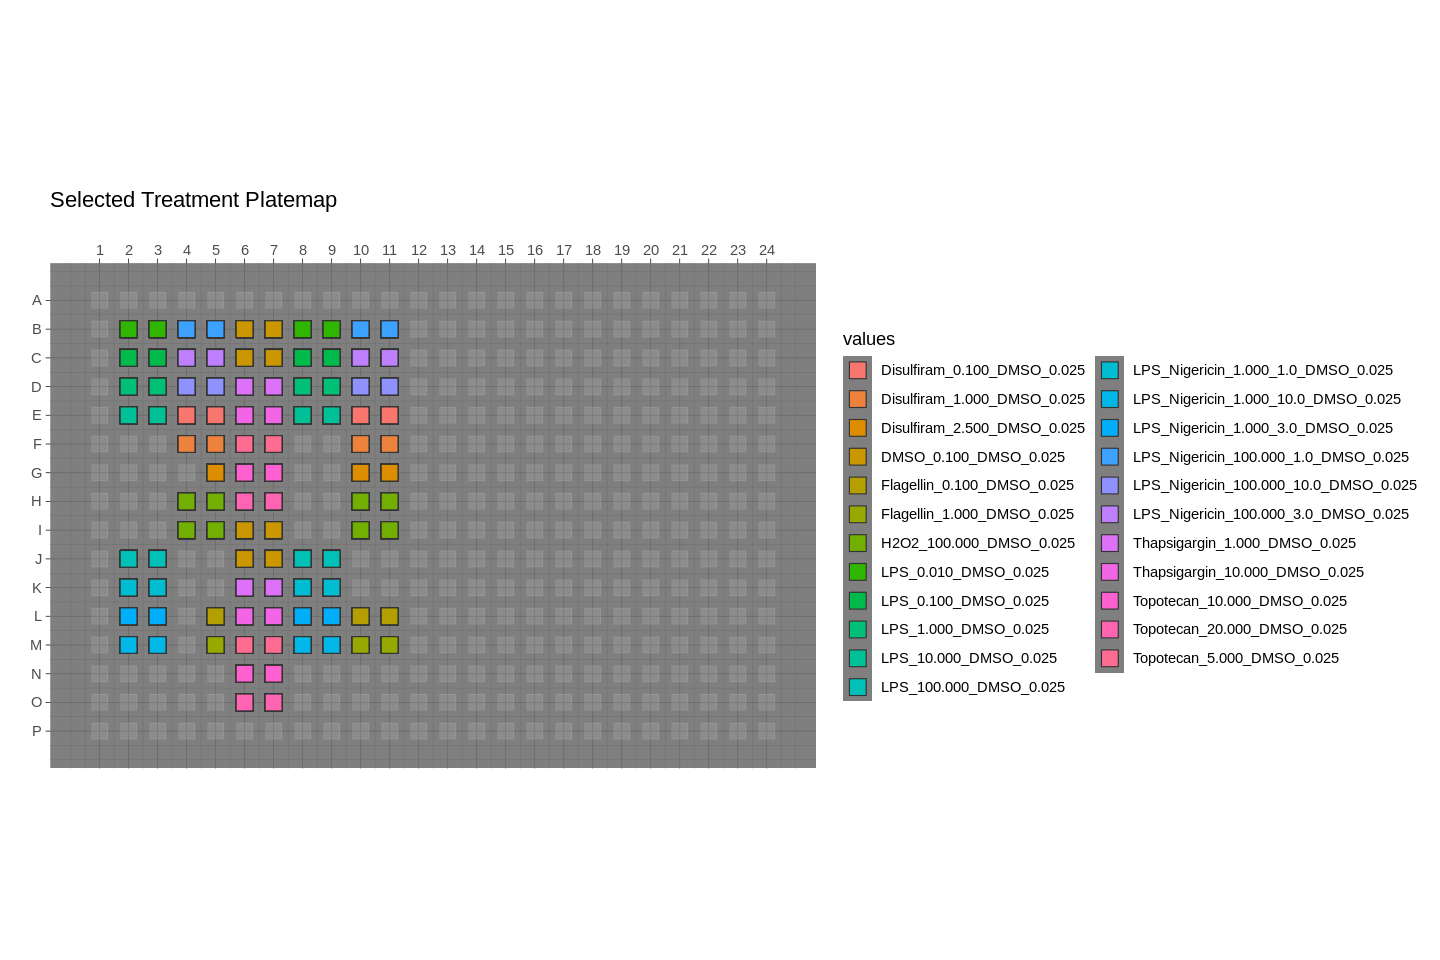

In [9]:
treatment_well_platemap <- file.path(paste0(enet_cp_fig_path,"treatment_platemap.png"))
# plot size set
options(repr.plot.width=12, repr.plot.height=8)
platemap_plot <- (
    raw_map(
        data = df$treatment,
        well = df$well,
        plate = 384)
    + ggtitle("Selected Treatment Platemap") 
    + theme_dark() 
)
ggsave(treatment_well_platemap, platemap_plot, width=12, height=8, dpi=500)
platemap_plot

In [10]:
# generate a platemap plot for the meta data
# read in the platemap data
platemap_df_path <- "../../../data/Interstellar_plate2_platemap.csv"
platemap_df <- read.csv(platemap_df_path)
# if cell_type is blank, set it to "blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- "blank"
# if treatment is blank, set it to "blank"
platemap_df$inducer1[platemap_df$inducer1 == ""] <- "blank"

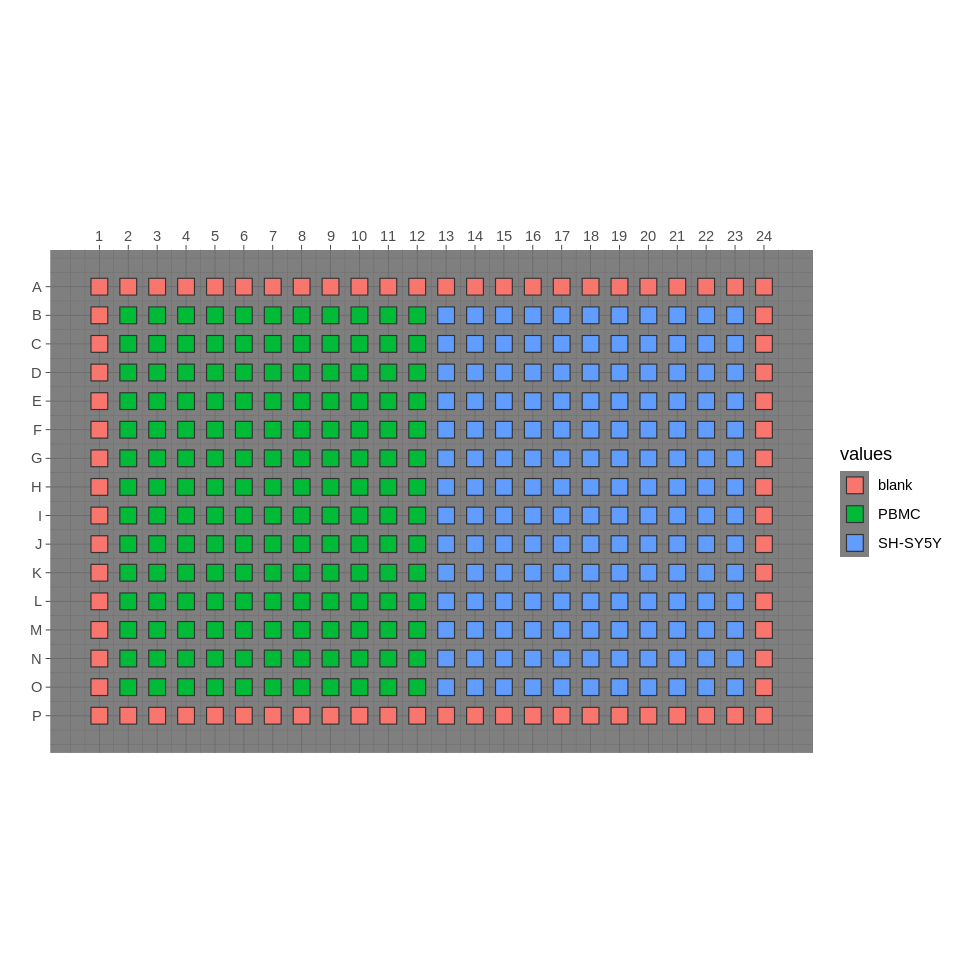

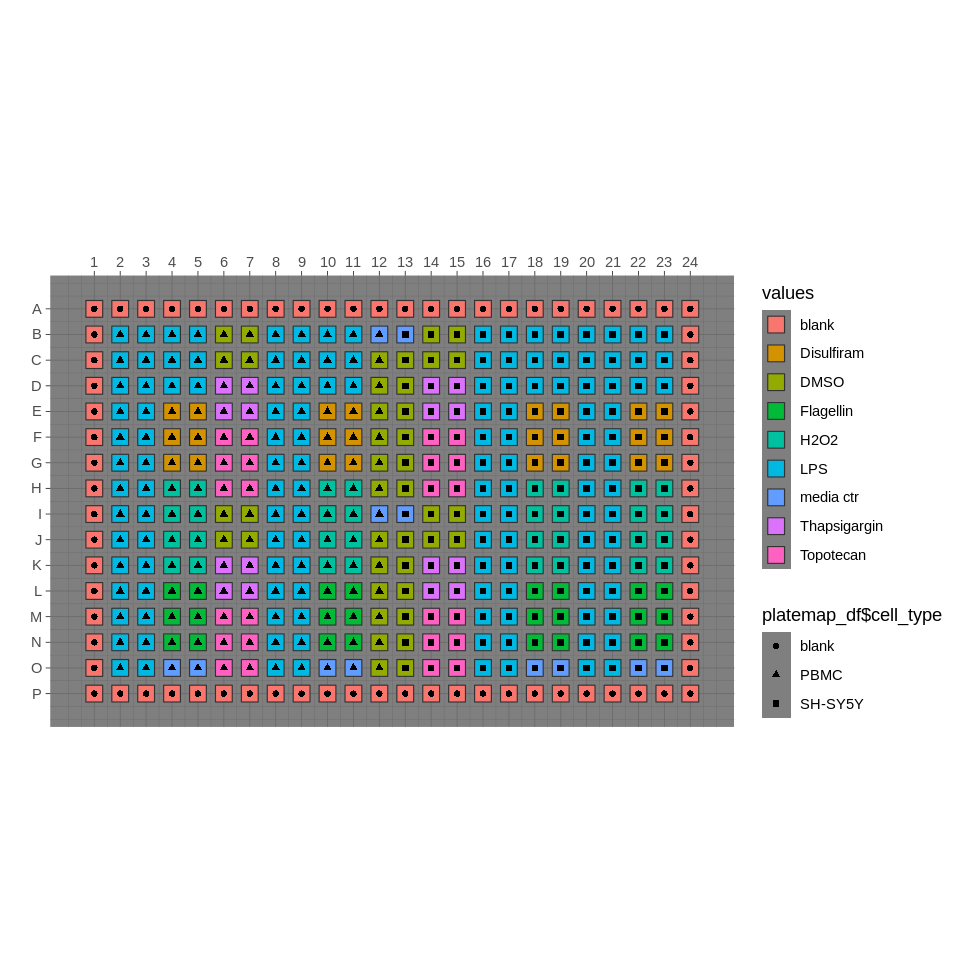

In [11]:
# plot size 
options(repr.plot.width=8, repr.plot.height=8)
# platemap of experimental contitions (cell type and inducer)
cell_type_well_platemap <- file.path(paste0(enet_cp_fig_path,"cell_type_well_platemap.png"))
# if path does not exist, create it
if (!file.exists(dirname(global_prediction_trend_path))) {
    print(dirname(global_prediction_trend_path))
    dir.create(dirname(global_prediction_trend_path), recursive = TRUE)
}
platemap_plot <- (
    raw_map(
        data = platemap_df$cell_type,
        well = platemap_df$well_id,
        plate = 384)
    + theme_dark() 
)
ggsave(cell_type_well_platemap, platemap_plot, width=5, height=5, dpi=500)
platemap_plot


inducer_well_platemap <- file.path(paste0(enet_cp_fig_path,"inducer_well_platemap.png"))
# if path does not exist, create it
if (!file.exists(dirname(global_prediction_trend_path))) {
    print(dirname(global_prediction_trend_path))
    dir.create(dirname(global_prediction_trend_path), recursive = TRUE)
}
platemap_plot <- (
    raw_map(
        data = platemap_df$inducer1,
        well = platemap_df$well_id,
        plate = 384)
    + theme_dark() 
    + ggplot2::geom_point(aes(shape = platemap_df$cell_type)) 
)
ggsave(inducer_well_platemap, platemap_plot, width=8, height=8, dpi=500)
platemap_plot